In [1]:
!gdown --id '1Y-1r9uY8ciTUlj6-mUkn2MeKVoeMskts'

Downloading...
From: https://drive.google.com/uc?id=1Y-1r9uY8ciTUlj6-mUkn2MeKVoeMskts
To: /content/ganimation_replicate.zip
100% 2.10G/2.10G [00:17<00:00, 120MB/s]


Note the source code was disgined specifcly for terminal, I modify several things in the source code so that it can also work in python sell, you may not be able to run it in terminal directly with the file inganimation_replicate.zip.

In [2]:
from google.colab import files
import zipfile
zip_ref = zipfile.ZipFile('/content/ganimation_replicate.zip', 'r') 
zip_ref.extractall('/content') 
zip_ref.close()

In [3]:
##load generation model
import os
os.chdir("/content/ganimation_replicate/model")

In [4]:
from base_model import BaseModel
from ganimation import GANimationModel

In [5]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
opt= Namespace(aus_nc=17, aus_pkl='aus_openface.pkl', batch_size=10, beta1=0.5, ckpt_dir='ckpts/celebA/ganimation/190327_161852/', data_root='datasets/celebA', epoch_count=1, final_size=128, gan_type='wgan-gp', gpu_ids=[], img_nc=3, imgs_dir='imgs', init_gain=0.02, init_type='normal', interpolate_len=5, lambda_aus=160.0, lambda_dis=1.0, lambda_mask=0, lambda_rec=10.0, lambda_tv=0, lambda_wgan_gp=10.0, load_epoch=30, load_size=148, log_file='logs.txt', lr=0.0001, lr_decay_iters=50, lr_policy='lambda', lucky_seed=1637713293, max_dataset_size=150, mode='test', model='ganimation', n_threads=6, name='211123_192133', ndf=64, ngf=64, niter=20, niter_decay=10, no_aus_noise=False, no_flip=False, no_test_eval=False, norm='instance', opt_file='opt.txt', plot_losses_freq=20000, print_losses_freq=100, resize_or_crop='none', results='results/celebA_ganimation_30', sample_img_freq=2000, save_epoch_freq=2, save_test_gif=False, serial_batches=False, test_csv='test_ids.csv', train_csv='train_ids.csv', train_gen_iter=5, use_dropout=False, visdom_display_id=0, visdom_env='main', visdom_port=8097)


In [6]:
import torch
model_path = '/content/ganimation_replicate/ckpts/celebA/ganimation/190327_161852/30_net_gen.pth'
state = torch.load(model_path)

In [7]:
os.chdir("/content/ganimation_replicate")
net=  GANimationModel()
net.initialize(opt)
net = getattr(net, 'net_'+'gen')
net.load_state_dict(state)

initialize network with normal
[Info] Successfully load trained weights for net_gen.


<All keys matched successfully>

In [8]:
#load AUs features from file
import pickle
import matplotlib.pyplot as plt
import numpy as np
saved_dict = {}
with open('/content/ganimation_replicate/datasets/celebA/aus_openface.pkl', 'rb') as f:
  saved_dict = pickle.load(f, encoding='latin1')


In [9]:
#define function to transform image to ternsor as generator required.
import torch
import os
from PIL import Image
import random
import numpy as np
import pickle
import torchvision.transforms as transforms

transform_list = []
transform_list.append(transforms.Lambda(lambda image: image))
transform_list.append(transforms.ToTensor())
transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
img2tensor = transforms.Compose(transform_list)

In [80]:
#define function convert tensor to image, change n to modify the ouput size of image
def tensor2im(input_image,n1,n2,imtype=np.uint8):
    if isinstance(input_image, torch.Tensor):
        image_tensor = input_image.data
    else:
        return input_image
    image_numpy = image_tensor[0].cpu().float().numpy()
    im = numpy2im(image_numpy, imtype).resize((n1, n2), Image.ANTIALIAS)
    return np.array(im)

In [11]:
def numpy2im(image_numpy, imtype=np.uint8):
      if image_numpy.shape[0] == 1:
          image_numpy = np.tile(image_numpy, (3, 1, 1))  
      image_numpy = (np.transpose(image_numpy, (1, 2, 0)) / 2. + 0.5) * 255.0
      image_numpy = image_numpy.astype(imtype)
      im = Image.fromarray(image_numpy)
      return im 


In [65]:
aa = plt.imread('/content/1510.jpg')


In [84]:
def changeface(image_array):
  pic = np.resize(image_array,128*128)
  pic = Image.fromarray(image_array)
  tar = img2tensor(pic)
  l = torch.tensor(saved_dict['000002']/5,dtype=torch.float)[None, ...]
  color_mask ,aus_mask, embed= net(tar[None,...],l)
  fake_img = aus_mask*tar + (1 - aus_mask) * color_mask
  fake_img = tensor2im(fake_img, image_array.shape[0],image_array.shape[1],imtype=np.uint8)
  return fake_img


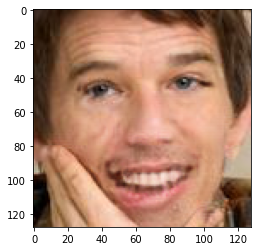

In [85]:
plt.imshow(changeface(aa))